# Orbit Propagator

In [ ]:
#=
using LinearAlgebra
#import Base: mod2pi

function sdot(s, μ=398600.436)
    x, y, xdot, ydot = s
    rsquared = x^2 + y^2
    xddot = -(μ*x)/(rsquared*sqrt(rsquared))
    yddot = -(μ*y)/(rsquared*sqrt(rsquared))
    return [xdot, ydot, xddot, yddot]
end

function propagate2D(s0, time=collect(1:1:86400), μ=398600.436)
    states = [s0]
    tprev = time[1]
    for t in time[2:end]
        s = states[end]
        dt = t-tprev
        sp = sdot(s)
        push!(states,s+dt*sp)
    end
    return states
end

#function rv2coes2D(s, μ=398600.436)
#    # Admittedly this is a weird concept
#    x, y, xdot, ydot = s
#    rvec = [x, y, 0.]
#    r = norm(rvec)
#    vvec = [xdot, ydot, 0.]
#    hvec = cross(rvec,vvec)
#    h = norm(hvec)
#    evec = (1/μ)*(cross(vvec,hvec) - μ*rvec/r)
#    e = norm(evec)
#    N = cross([0,0,1],hvec)
#    cosω = dot(N,evec)/(norm(N)*e)
#    a = h^2/(μ*(1-e^2))
#    E = acos(x/a)
#    M = E - e*sin(E)
#    return h, a, e, cosω, M
#end

#function mod2pi(N::Array{Float64,1})
#    out = []
#    for n in N
#        push!(out,mod2pi(n))
#    end
#    return out
#end

#function coes2rv2D(coes, μ=398600.436)
#    h,i,ω,Ω,e,M = coes
#    return s=[]
#end

#function propagate2D(s, time=collect(1:1:86400), μ=398600.436)
#    x, y, xdot, ydot = s
#    h, a, e, cosω, M = rv2coes2D(s)
#    n = sqrt(μ/a^3)
#    Mt = M .+ n*time
#    Mt = mod2pi(Mt)
#    return Mt
#end

# Test Orbit
μ = 398600.436
testsat = [0, -6878, sqrt(μ/6878), 0]
statehistory = propagate2D(testsat,collect(1:30:86400));

# Define an SSA POMDP

In [1]:
using POMDPs
using StaticArrays
using POMDPModelTools
using Random
using Distributions
using Compose
using DifferentialEquations
using LinearAlgebra
using POMDPGifs,Cairo,Fontconfig

In [2]:
struct telescope
    pos::SVector{1,Float64}  # psuedo-latitude (for 2D problem)
    fov::SVector{1,Float64}  # field of view (half angle)
    catalog::SVector{1,Bool} # Binary catalog from the perspective of the telescope (1: object is in view, 0: otherwise)
    # TBD: Add pointing
end

struct satellite
    statevec::SVector{4, Float64}  # 2D orbital state vector
    status::SVector{1,Symbol}      # Characterization ID
end

struct SSAState
    telescope::telescope
    satellite::satellite
end


In [4]:
function VisCheck(sat::satellite,scope::telescope)
    r = sat.statevec[1:2]
    z = [6378*cos(scope.pos[1]),6378*sin(scope.pos[1])]
    los = r - z    
    if acos(dot(los,z)/(norm(los)*norm(z))) < scope.fov[1] && los[2]*z[2]>0
        return true
    else
        return false
    end
end

#for s in ssa.states[1:2879]
#    vis = VisCheck(s.satellite,s.telescope)
#    #@show vis,s.satellite.statevec
#end


VisCheck (generic function with 1 method)

In [5]:
struct SSAPOMDP <: POMDP{SSAState, Symbol, Symbol} # POMDP{State, Action, Observation}
    size::SVector{2, Int}          # Number of satellites and number of telescopes
    sats::satellite                # Initial satellite objects
    scopes::telescope              # Initial telescope objects
    states::Array{SSAState,1}      # All possible states
    stateind::Dict{SSAState,Int64} # Dictionary of all possible states with index
    actions::Array{Symbol,1}       # All possible actions
    actionind::Dict{Symbol,Int64}  # Dictionary of actions with index
    obs::Array{Symbol,1}           # All possible observations
    obsind::Dict{Symbol,Int64}     # Dictionary of observations with index
    statehistory::DiffEqArray{Float64,2,Array{Array{Float64,1},1},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}
end

In [6]:
function sdot(ds,s,p,t,μ=398600.436)
    x, y, xdot, ydot = s
    rsquared = x^2 + y^2
    xddot = -(μ*x)/(rsquared*sqrt(rsquared))
    yddot = -(μ*y)/(rsquared*sqrt(rsquared))
    ds[1:4] = [xdot, ydot, xddot, yddot]
end

function SSAstates(sat::satellite,scope::telescope,statehistory,size=[1,1])
    states = SSAState[]
    stateind = Dict{SSAState, Int64}()
    counter = 0
    n = size[1] # number of telescopes
    m = size[2] # number of satellites
    
    for ii in [:stable,:anomaly,:dead]
        for kk in statehistory
            counter += 1
            satstates = satellite(SVector{4}(kk),SVector{1}(ii))
            scopestates = telescope(scope.pos,scope.fov,SVector{1}(VisCheck(satstates,scope)))
            push!(states,SSAState(scopestates,satstates))
            push!(stateind, SSAState(scopestates,satstates)=>counter)
        end
    end
    return states, stateind
end

μ = 398600.436
sat = satellite(SVector(0, -6878, sqrt(μ/6878), 0),SVector(:nodata))
scope = telescope(SVector(pi/2),SVector(pi/4),SVector(false))
s0 = Float64[]
for x in sat.statevec
    push!(s0,x)
end    
tspan = (0.0,86400.0)
prob = ODEProblem(sdot,s0,tspan)
sol = DifferentialEquations.solve(prob)
statehistory = sol(tspan[1]:30:tspan[2])
states, stateind = SSAstates(sat,scope,statehistory);


In [7]:
function SSAobs(size=[1,1])
    obs = SVector[]
    obsind = Dict{Symbol, Int64}()
    counter = 0
    n = size[1] # number of telescopes
    m = size[2] # number of satellites
    for i in [:stable,:anomaly,:dead]
        counter+=1
        push!(obs,SVector(i))
        push!(obsind, i=>counter)
    end
    return obs, obsind
end

obs, obsind = SSAobs();
typeof(obs)

Array{SArray{Tuple{S},T,1,S} where T where S,1}

In [8]:
# Define POMDP Spaces (https://juliapomdp.github.io/POMDPs.jl/latest/interfaces/#Spaces-1)
POMDPs.actions(m::SSAPOMDP) = m.actions
POMDPs.states(m::SSAPOMDP) = m.states
POMDPs.observations(m::SSAPOMDP) = m.obs
POMDPs.discount(m::SSAPOMDP) = 0.99
POMDPs.stateindex(m::SSAPOMDP, s) = m.stateind[s]
POMDPs.actionindex(m::SSAPOMDP, a) = m.actionind[a]
POMDPs.obsindex(m::SSAPOMDP, o) = m.obsind[o]


In [9]:
# Create a method of SSAPOMDP to run as default
function SSAPOMDP(; size=(1,1), 
                    sat_init=satellite(SVector(0, -14378, sqrt(μ/14378), 0),SVector(:stable)),
                    scopes = telescope(SVector(pi/2),SVector(pi/4),SVector(false)), 
                    rng::AbstractRNG=Random.GLOBAL_RNG)
    
    s0 = Float64[]
    for x in sat_init.statevec
        push!(s0,x)
    end    
    tspan = (0.0,86400.0)
    prob = ODEProblem(sdot,s0,tspan)
    sol = DifferentialEquations.solve(prob)
    statehistory = sol(tspan[1]:120:tspan[2])
    
    states, stateind = SSAstates(sat_init,scopes,statehistory);    
    actions = [:observe,:alert]
    actionind = Dict(:observe=>1, :alert=>2)
    obs = [:stable,:anomaly,:dead]
    obsind = Dict(:stable=>1, :anomaly=>2, :dead=>3)
    
    SSAPOMDP(size, sat_init, scopes, states, stateind, actions, actionind, obs, obsind, statehistory)
end


SSAPOMDP

In [10]:
# So the rand function doesn't break with an SSAPOMDP... just run my SSAPOMDP init method
Random.rand(rng::AbstractRNG, ::Random.SamplerType{SSAPOMDP}) = SSAPOMDP(rng=rng)



In [12]:
# Transition Function
function POMDPs.transition(m::SSAPOMDP, s, a)
    # Number of possible status values for a satellite
    n_states = length(m.states)
    n_status = n_states/length(m.statehistory)
    
    # Current Index
    indx = m.stateind[s]
        
    # Only n_status possible states (all have the same position and velocity, only the status varies)
    newstates = SSAState[]
    for i in 1:n_status
        next_indx = Int64(mod((indx+1)+((i-1)*n_states/n_status),n_states))
        if next_indx == 0
            next_indx = Int64(n_states)
        end
        push!(newstates,m.states[next_indx])
    end
     
    # Set appropriate probability for each new state
    probs = Float64[]
    for sp in newstates
        if a == :observe
             if s.satellite.status[1] == :stable
                if sp.satellite.status[1] == :anomaly
                    push!(probs, 0.01)
                elseif sp.satellite.status[1] == :dead
                    push!(probs, 0.0)
                else
                    push!(probs, 1 - 0.01 - 0.0)
                end
             elseif s.satellite.status[1] == :anomaly
                if sp.satellite.status[1] == :dead
                    push!(probs, 0.005)  # This should probably be a function of previous states as well... meaning not markov
                elseif sp.satellite.status[1] == :stable
                    push!(probs,0.)
                else
                    push!(probs, 1 - 0.005 - 0)
                end
            else
                if sp.satellite.status[1] == :dead
                    push!(probs, 1.)
                else
                    push!(probs, 0.)
                end
            end
        elseif a == :alert
            if s.satellite.status[1] == :stable
                if sp.satellite.status[1] == :anomaly
                    push!(probs, 0.01)
                elseif sp.satellite.status[1] == :dead
                    push!(probs, 0.0)
                else
                    push!(probs, 1 - 0.01 - 0.0)
                end        
            elseif s.satellite.status[1] == :anomaly
                if sp.satellite.status[1] == :stable
                    push!(probs, 0.8)
                elseif sp.satellite.status[1] == :anomaly
                    push!(probs, 0.195)
                else
                    push!(probs, 1 - 0.8 - 0.195)
                end
            else
                if sp.satellite.status[1] == :dead
                    push!(probs, 1.)
                else
                    push!(probs, 0.)
                end
            end
        end  
    end
    return SparseCat(newstates, probs)
end

#Test
#out = POMDPs.transition(ssa, ssa.states[45],:alert)
#showdistribution(out)


In [13]:
function POMDPs.observation(m::SSAPOMDP, s::SSAState, a::Symbol, sp::SSAState)
    if s.telescope.catalog[1]
        if s.satellite.status[1] == :stable
            return SparseCat([:stable,:anomaly,:dead], [0.9, 0.1, 0.0])
        elseif s.satellite.status[1] == :anomaly
            return SparseCat([:stable,:anomaly,:dead], [0.09, 0.9, 0.01])
        elseif s.satellite.status[1] == :dead
            return SparseCat([:stable,:anomaly,:dead], [0.0, 0.0, 1.0])
        end
    else
        return SparseCat([:stable,:anomaly,:dead], [1/3, 1/3, 1/3])
    end
end

function POMDPs.observation(m::SSAPOMDP, s::SSAState)
    if s.telescope.catalog[1]
        if s.satellite.status[1] == :stable
            return SparseCat([:stable,:anomaly,:dead], [0.9, 0.1, 0.0])
        elseif s.satellite.status[1] == :anomaly
            return SparseCat([:stable,:anomaly,:dead], [0.09, 0.9, 0.01])
        elseif s.satellite.status[1] == :dead
            return SparseCat([:stable,:anomaly,:dead], [0.0, 0.0, 1.0])
        end
    else
        return SparseCat([:stable,:anomaly,:dead], [1/3, 1/3, 1/3])
    end
end

#Test
#out = POMDPs.observation(ssa, ssa.states[45])
#showdistribution(out)


In [14]:
function POMDPs.reward(m::SSAPOMDP, s, a)
    if s.satellite.status[1] == :dead
        return -1.
    elseif a == :alert
        if s.satellite.status[1] == :anomaly
            return 1000.
        else
            return -500.
        end
    elseif a == :observe
        if s.telescope.catalog[1]
            return 1.
        else
            return 0.
        end
    else
        return 0.
    end
end


In [15]:
function POMDPs.initialstate_distribution(m::SSAPOMDP)
    # return POMDPModelTools.Uniform(x for x in m.states[1:200])
     return POMDPModelTools.Deterministic(m.states[1])
end


In [16]:
function POMDPs.isterminal(m::SSAPOMDP, s) 
    n_status = length(m.states)/length(m.statehistory)
    a = m.stateind[s]/length(m.statehistory)
    out = false
    for n in 1:n_status
        if ~out
            if a == n
                out = true
            end
        end
    end
    return out
end

In [17]:
function POMDPModelTools.render(m::SSAPOMDP, step)
    fov = m.scopes.fov[1]
    x0 = 6378*cos(m.scopes.pos[1])
    y0 = 6378*sin(m.scopes.pos[1])
    sc = 6 # scale
    parent = context(0.5,0.5,min(w,h),min(w,h))
    scaled = context(units=UnitBox(0, 0, sc*6378, -sc*6378))
    Background  = compose(context(units=UnitBox(0, 0, sc*6378, -sc*6378)), Compose.circle(0.0,0.0,sc*6378), fill("white"),Compose.stroke("white"))
    Earth  = compose(context(units=UnitBox(0, 0, sc*6378, -sc*6378)), ellipse(0.0,0.0,6378,6378), fill("blue"),Compose.stroke("black"),fillopacity(1.))
    Scope  = compose(context(units=UnitBox(0, 0, sc*6378, -sc*6378)), ngon(x0, y0, 500, 8),Compose.stroke("black"), fill("gray"))
    FOV    = compose(context(units=UnitBox(0, 0, sc*6378, -sc*6378)), polygon([(x0,y0), (x0+sc*6378*sin(fov),y0+sc*6378*cos(fov)), (x0+sc*6378*sin(-fov),y0+sc*6378*cos(-fov))]),fill("green"),fillopacity(0.1))
    
    if haskey(step,:b)
        b = step[:b]
        # Number of possible status values for a satellite
        n_states = length(b.b)
        n_status = 3.0
    
        # Current Index
        indx = argmax(b.b)
        
        # Only n_status possible states (all have the same position and velocity, only the status varies)
        state_indx = Int64[]
        for i in 1:n_status
            next_indx = Int64(mod((indx)+((i-1)*n_states/n_status),n_states))
            if next_indx == 0
                next_indx = Int64(n_states)
            end
            push!(state_indx,next_indx)
        end
        sort!(state_indx)
        b_stable = pdf(b,b.state_list[state_indx[1]])
        b_anom   = pdf(b,b.state_list[state_indx[2]])
        b_dead   = pdf(b,b.state_list[state_indx[3]])
        b1 = compose(context(), Compose.text(-0.7, 0.35, string("b(stable): ",b_stable)),Compose.stroke("black"))
        b2 = compose(context(), Compose.text(-0.7, 0.4, string("b(anomaly): ",b_anom)),Compose.stroke("black"))
        b3 = compose(context(), Compose.text(-0.7, 0.45, string("b(dead): ",b_dead)),Compose.stroke("black"))
    else
        b1 = nothing
        b2 = nothing
        b3 = nothing
    end

    
    if haskey(step,:s)
        s = step[:s].satellite.statevec
        sat = compose(context(units=UnitBox(0, 0, sc*6378, -sc*6378)), star(s[1], s[2], sc*100, 5),Compose.stroke("black"),fill("gold"))
        state = compose(context(), Compose.text(-.7, 0.25, string("State: ", step[:s].satellite.status[1])),Compose.stroke("black"))

        if step[:s].telescope.catalog[1]
            vis = compose(context(units=UnitBox(0, 0, sc*6378, -sc*6378)), ellipse(s[1], s[2], sc*200, sc*200),Compose.stroke("black"),fill("green"))
            
        else
            vis = nothing
        end
    else
        sat = nothing
        vis = nothing
        state = nothing
    end
    
    if haskey(step,:t)
        time = compose(context(), Compose.text(-0.7, 0.2, string("Timestep: ",step[:t])),Compose.stroke("black"))
    else
        time = nothing
    end
       
    if haskey(step,:a)
        action = compose(context(), Compose.text(-.7, 0.3, string("Action: ", step[:a])),Compose.stroke("black"))
    else
        action = nothing
    end
    
    return compose(parent,Earth,Scope,FOV,sat,time,state,action,b1,b2,b3,Background)


end

#= Values in step
t: the time step index
s: the state at the beginning of the step
a: the action
sp: the state at the end of the step (s')
r: the reward for the step
o: the observation
b: the belief at the
bp: the belief at the end of the step
i: info from the model when the state transition was calculated
ai: info from the policy decision
ui: info from the belief update
=#


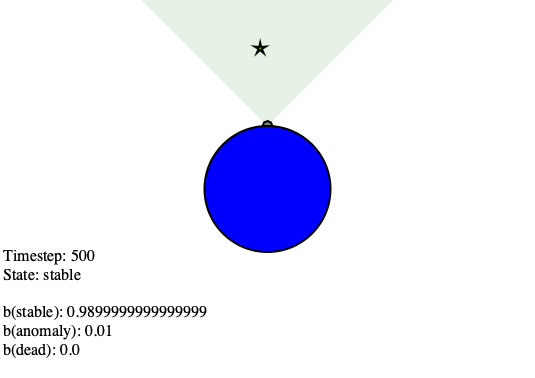

In [23]:
# Test
ssaGEO = SSAPOMDP()
ssa_filter = DiscreteUpdater(ssaGEO);
t = 500
a = :observe
o = :stable
b1 = update(ssa_filter, b₀, a, o)
POMDPModelTools.render(ssaGEO,Dict(:s => ssaGEO.states[t], :t => t, :b => b1))


# Explore the POMDP

In [19]:
using POMDPPolicies
using POMDPSimulators
using BeliefUpdaters


In [21]:
function findstates(m::SSAPOMDP,s::SSAState)
    # Number of possible status values for a satellite
    n_states = length(m.states)
    n_status = n_states/length(m.statehistory)
    
    # Current Index
    indx = m.stateind[s]
        
    # Only n_status possible states (all have the same position and velocity, only the status varies)
    state_indx = Int64[]
    for i in 1:n_status
        next_indx = Int64(mod((indx)+((i-1)*n_states/n_status),n_states))
        if next_indx == 0
            next_indx = Int64(n_states)
        end
        push!(state_indx,next_indx)
    end

    return sort(state_indx)
end

ssa = SSAPOMDP()
s_new = findstates(ssa,ssa.states[45])

3-element Array{Int64,1}:
   45
  766
 1487

In [22]:
# Create Model
ssa = SSAPOMDP()

# Initial Belief
b₀ = Deterministic(ssa.states[1])

# Max Steps
prop_len = length(ssa.statehistory)-1

# Always Observe Policy
AlwaysObserve = FunctionPolicy(o -> :observe);

# Belief Updater
ssa_filter = DiscreteUpdater(ssa);

# Monte Carlo Rollout
rsum = 0.0
N = 100
sim = RolloutSimulator(max_steps=prop_len)
hr = HistoryRecorder(max_steps=prop_len)
for i in 1:N 
    if i<N
        r = simulate(sim, ssa, AlwaysObserve, ssa_filter)
        rsum += r
    else
        history = simulate(hr, ssa, AlwaysObserve, ssa_filter)
        #=for j in 1:length(history[:s])
            s = history[j][:s].satellite.status[1]
            a = history[j][:a]
            b = history[j][:b]
            indx = findstates(ssa,history[j][:s])
            b_stable = pdf(b,ssa.states[indx[1]])
            b_anomaly = pdf(b,ssa.states[indx[2]])
            b_dead = pdf(b,ssa.states[indx[3]])
            #@show j,s,a,b_stable,b_anomaly,b_dead
        end =#
        r = discounted_reward(history)
        rsum += r
    end
    #@show i,r,rsum/i
end

avg_reward = rsum/N


-3.531762709886572

In [24]:
# Create Model
ssa = SSAPOMDP()

# Initial Belief
b₀ = Deterministic(ssa.states[1])

# Max Steps
prop_len = length(ssa.statehistory)-1

# Always Observe Policy
AlwaysAlert = FunctionPolicy(o -> :alert);

# Belief Updater
ssa_filter = DiscreteUpdater(ssa);

# Monte Carlo Rollout
rsum = 0.0
N = 100
sim = RolloutSimulator(max_steps=prop_len)
hr = HistoryRecorder(max_steps=prop_len)
for i in 1:N 
    if i<N
        r = simulate(sim, ssa, AlwaysAlert, ssa_filter)
        rsum += r
    else
        history = simulate(hr, ssa, AlwaysAlert, ssa_filter)
        #=for j in 1:length(history[:s])
            s = history[j][:s].satellite.status[1]
            a = history[j][:a]
            b = history[j][:b]
            indx = findstates(ssa,history[j][:s])
            b_stable = pdf(b,ssa.states[indx[1]])
            b_anomaly = pdf(b,ssa.states[indx[2]])
            b_dead = pdf(b,ssa.states[indx[3]])
            #@show j,s,a,b_stable,b_anomaly,b_dead
        end =#
        r = discounted_reward(history)
        rsum += r
    end
    #@show i,r,rsum/i
end

avg_reward = rsum/N


-47553.27794072929

In [25]:
alertpolicy = FunctionPolicy(
    function (b) # b is belief containing a full SSA.STATE
        
        # Number of possible status values for a satellite
        n_states = length(b.b)
        n_status = 3.0
    
        # Current Index
        indx = argmax(b.b)
        
        # Only n_status possible states (all have the same position and velocity, only the status varies)
        state_indx = Int64[]
        for i in 1:n_status
            next_indx = Int64(mod((indx)+((i-1)*n_states/n_status),n_states))
            if next_indx == 0
                next_indx = Int64(n_states)
            end
            push!(state_indx,next_indx)
        end

        sort!(state_indx)
        
        # Heurustic
        if pdf(b,b.state_list[state_indx[2]]) > 0.50
            return :alert
        else
            return :observe
        end
    end    
)

FunctionPolicy{var"#8#9"}(var"#8#9"())

In [26]:
# Create Model
ssa = SSAPOMDP()

# Initial Belief
b₀ = Deterministic(ssa.states[1])

# Max Steps
prop_len = length(ssa.statehistory)-1

# Always Observe Policy
policy = alertpolicy

# Belief Updater
ssa_filter = DiscreteUpdater(ssa);

# Monte Carlo Rollout
rsum = 0.0
N = 100
sim = RolloutSimulator(max_steps=prop_len)
hr = HistoryRecorder(max_steps=prop_len)
for i in 1:N 
    if i<N
        r = simulate(sim, ssa, policy, ssa_filter)
        rsum += r
    else
        history = simulate(hr, ssa, policy, ssa_filter)
        #=for j in 1:length(history[:s])
            s = history[j][:s].satellite.status[1]
            a = history[j][:a]
            b = history[j][:b]
            r = history[j][:r]
            indx = findstates(ssa,history[j][:s])
            b_stable = pdf(b,ssa.states[indx[1]])
            b_anomaly = pdf(b,ssa.states[indx[2]])
            b_dead = pdf(b,ssa.states[indx[3]])
            @show j,s,a,b_anomaly,r
        end =#
        r = discounted_reward(history)
        rsum += r
    end
    @show i,r,rsum/i
end

avg_reward = rsum/N


(i, r, rsum / i) = (1, -235.39960708726085, -235.39960708726085)
(i, r, rsum / i) = (2, 122.18288390593908, -56.608361590660884)
(i, r, rsum / i) = (3, 511.9918087042292, 132.9250285076358)
(i, r, rsum / i) = (4, 229.23151093287052, 157.0016491139445)
(i, r, rsum / i) = (5, -195.05260966728167, 86.59079735769926)
(i, r, rsum / i) = (6, -688.8270705773701, -42.6455139648123)
(i, r, rsum / i) = (7, 754.9630669493413, 71.29856902292393)
(i, r, rsum / i) = (8, -648.0780149303673, -18.623503971237483)
(i, r, rsum / i) = (9, -74.64520817088543, -24.848137771198367)
(i, r, rsum / i) = (10, 510.48861661523745, 28.685537667445214)
(i, r, rsum / i) = (11, 389.8381094217347, 61.517589645107904)
(i, r, rsum / i) = (12, 263.17095171948, 78.3220364846389)
(i, r, rsum / i) = (13, 280.49381189857536, 93.87371151648017)
(i, r, rsum / i) = (14, 13.218627793261287, 88.11263410767882)
(i, r, rsum / i) = (15, 44.00573768355003, 85.17217434607024)
(i, r, rsum / i) = (16, -544.2557753046934, 45.8329274928975

176.73370276539504

In [27]:
Unknownpolicy = FunctionPolicy(
    function (b) # b is belief containing a full SSA.STATE
        
        # Number of possible status values for a satellite
        n_states = length(b.b)
        n_status = 3.0
    
        # Current Index
        indx = argmax(b.b)
        
        # Only n_status possible states (all have the same position and velocity, only the status varies)
        state_indx = Int64[]
        for i in 1:n_status
            next_indx = Int64(mod((indx)+((i-1)*n_states/n_status),n_states))
            if next_indx == 0
                next_indx = Int64(n_states)
            end
            push!(state_indx,next_indx)
        end

        sort!(state_indx)
        
        # Heurustic
        if pdf(b,b.state_list[state_indx[2]]) >= 1/3
            return :alert
        else
            return :observe
        end
    end    
)

FunctionPolicy{var"#10#11"}(var"#10#11"())

In [28]:
# Create Model
ssa = SSAPOMDP()

# Initial Belief
b₀ = Deterministic(ssa.states[1])

# Max Steps
prop_len = length(ssa.statehistory)-1

# Always Observe Policy
policy = Unknownpolicy

# Belief Updater
ssa_filter = DiscreteUpdater(ssa);

# Monte Carlo Rollout
rsum = 0.0
N = 100
sim = RolloutSimulator(max_steps=prop_len)
hr = HistoryRecorder(max_steps=prop_len)
for i in 1:N 
    if i<N
        r = simulate(sim, ssa, policy, ssa_filter)
        rsum += r
    else
        history = simulate(hr, ssa, policy, ssa_filter)
        #=for j in 1:length(history[:s])
            s = history[j][:s].satellite.status[1]
            a = history[j][:a]
            b = history[j][:b]
            r = history[j][:r]
            indx = findstates(ssa,history[j][:s])
            b_stable = pdf(b,ssa.states[indx[1]])
            b_anomaly = pdf(b,ssa.states[indx[2]])
            b_dead = pdf(b,ssa.states[indx[3]])
            @show j,s,a,b_anomaly,r
        end =#
        r = discounted_reward(history)
        rsum += r
    end
    #@show i,r,rsum/i
end

avg_reward = rsum/N


-26.83320030630015

# Solve the POMDP

In [29]:
using SARSOP
using QMDP
using POMDPSimulators

ssa = SSAPOMDP();
solver = QMDPSolver()
ssapolicy = POMDPPolicies.solve(solver, ssa)
N = 100
rsum = 0.0
for i in 1:N
    rsum += simulate(RolloutSimulator(max_steps=length(ssa.statehistory)), ssa, ssapolicy, ssa_filter)
    @show i,rsum/i
end

results = rsum/N



(i, rsum / i) = (1, 26.362511420258453)
(i, rsum / i) = (2, 165.09761387705524)
(i, rsum / i) = (3, 102.98638795137718)
(i, rsum / i) = (4, 123.81718520526957)
(i, rsum / i) = (5, 203.8446516858872)
(i, rsum / i) = (6, 253.9481840649139)
(i, rsum / i) = (7, 434.3133909871488)
(i, rsum / i) = (8, 373.5050416154882)
(i, rsum / i) = (9, 325.22229002587704)
(i, rsum / i) = (10, 403.2813049808067)
(i, rsum / i) = (11, 378.7575146259817)
(i, rsum / i) = (12, 358.97329728480963)
(i, rsum / i) = (13, 337.7281795980374)
(i, rsum / i) = (14, 377.9880486840953)
(i, rsum / i) = (15, 333.1203077575311)
(i, rsum / i) = (16, 328.4714737106827)
(i, rsum / i) = (17, 299.80251591477673)
(i, rsum / i) = (18, 282.6681826023724)
(i, rsum / i) = (19, 260.52559849654)
(i, rsum / i) = (20, 295.4221447033078)
(i, rsum / i) = (21, 347.66136994756033)
(i, rsum / i) = (22, 430.40150251761423)
(i, rsum / i) = (23, 434.200375099684)
(i, rsum / i) = (24, 421.9255705402123)
(i, rsum / i) = (25, 410.37965671155376)
(i

293.6491966979274

b_anomaly = 0.05378575912773382
b_anomaly = 0.9386486218929322
b_anomaly = 0.023320724867400132
b_anomaly = 0.950089439379463
b_anomaly = 0.9386492606156039
b_anomaly = 0.9380122432944559
b_anomaly = 0.2812589554306653
b_anomaly = 0.0007610075810352329
b_anomaly = 1.4850870909237785e-6
b_anomaly = 2.8959240981110013e-9
b_anomaly = 5.647052007556231e-12
b_anomaly = 1.1011751414796403e-14


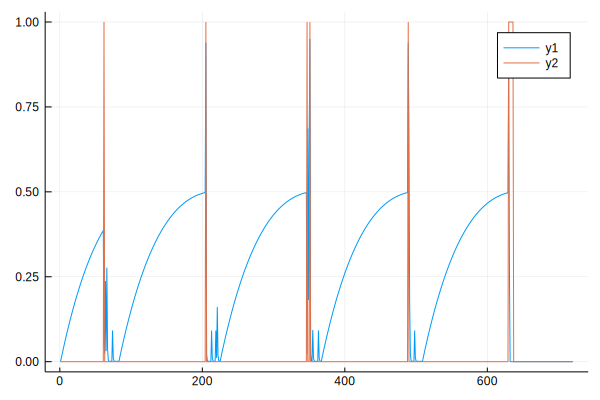

In [30]:
using Plots

ba = Float64[]
avec = Float64[]
history = simulate(hr, ssa, ssapolicy, ssa_filter)
for j in 1:length(history[:s])
    s = history[j][:s].satellite.status[1]
    a = history[j][:a]
    b = history[j][:b]
    indx = findstates(ssa,history[j][:s])
    b_anomaly = pdf(b,ssa.states[indx[2]])
    push!(ba,b_anomaly)
    if a == :observe
        push!(avec,0)
    else
         push!(avec,1)
        @show b_anomaly
    end

end

Plots.plot(ba)
Plots.plot!(avec)

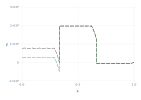

In [31]:
using Gadfly

p = ssapolicy
set_default_plot_format(:svg)
layers = []
colors = Dict(:observe=>colorant"black", :alert=>colorant"green")
for i in 1:length(p.alphas)
    push!(layers, layer(x=collect(LinRange(0,1,length(p.alphas[1]))), y=p.alphas[i], Geom.line, Theme(default_color=colors[p.action_map[i]], line_style=[:dash])))
end
display(Gadfly.plot(layers...))


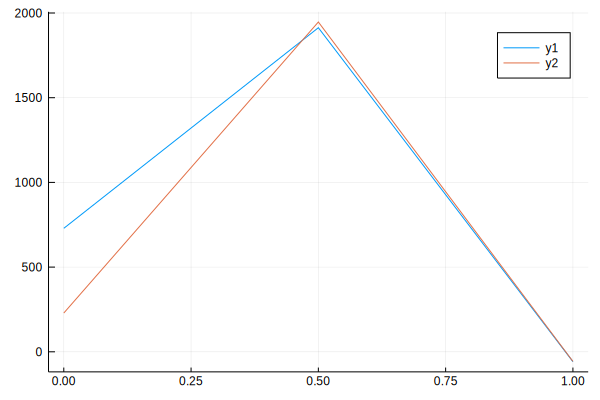

In [32]:
Plots.plot(collect(LinRange(0,1,length(ssapolicy.alphas[1]))),ssapolicy.alphas[1])
Plots.plot!(collect(LinRange(0,1,length(ssapolicy.alphas[2]))),ssapolicy.alphas[2])

p = ssapolicy
Plots.plot([0,.5,1],[mean(p.alphas[1][1:720]),mean(p.alphas[1][720:720*2]),mean(p.alphas[1][720*2:720*3])])
Plots.plot!([0,.5,1],[mean(p.alphas[2][1:720]),mean(p.alphas[2][720:720*2]),mean(p.alphas[2][720*2:720*3])])


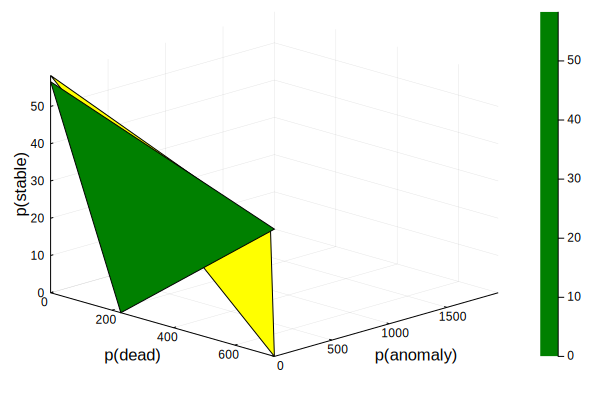

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/liamsmith/.julia/packages/Plots/cc8wh/src/backends/gr.jl:514


In [33]:
p = ssapolicy
labels = ["observe1" "alert"]
surface()
alpha = p.alphas[1]
pt1 = [0,0,mean(alpha[1:720]),0]
pt2 = [0,mean(alpha[720:720*2]),0,0]
pt3 = [-mean(alpha[720*2:720*3]),0,0,-mean(alpha[720*2:720*3])]
surface!(pt1,pt2,pt3,fillcolor = plot_color(:yellow, 0.3))

alpha = p.alphas[2]
pt1 = [0,0,mean(alpha[1:720]),0]
pt2 = [0,mean(alpha[720:720*2]),0,0]
pt3 = [-mean(alpha[720*2:720*3]),0,0,-mean(alpha[720*2:720*3])]
surface!(pt1,pt2,pt3,fillcolor = plot_color(:green, 0.3), camera=(45,45), xlabel = "p(dead)",ylabel = "p(anomaly)",zlabel = "p(stable)")



# Visualization

In [34]:
ssa = SSAPOMDP()
@show makegif(ssa, alertpolicy, ssa_filter, filename="ssa.gif",fps=30)


Rendering 720 steps...100%|█████████████████████████████| Time: 0:00:29


makegif(ssa, alertpolicy, ssa_filter, filename="ssa.gif", fps=30) = POMDPGifs.SavedGif("ssa.gif")


POMDPGifs.SavedGif("ssa.gif")

In [35]:
prop_len = length(ssa.statehistory)-1
hr = HistoryRecorder(max_steps=prop_len)
history = simulate(hr, ssa, alertpolicy, ssa_filter);
#history = simulate(hr, ssa, ssapolicy, ssa_filter);

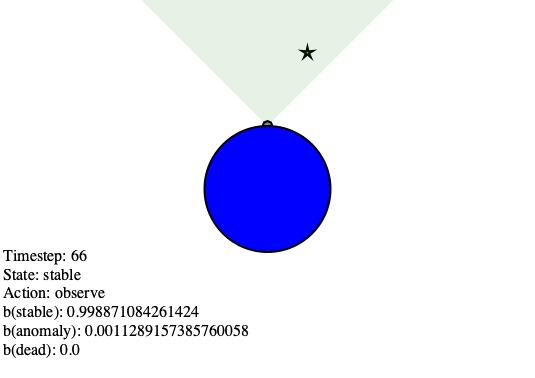

In [36]:
t = 66
POMDPModelTools.render(ssa,Dict(:s => history[t][:s], :t => t, :b => history[t][:b], :a => history[t][:a]))

In [ ]:
ssa = SSAPOMDP();

solver = SARSOPSolver()
ssapolicy2 = POMDPPolicies.solve(solver, ssa)


Generating a pomdpx file: model.pomdpx

Loading the model ...
  input file   : model.pomdpx
  loading time : 6.65s 

SARSOP initializing ...
  initialization time : 0.63s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0.63    0       0        -5.08707   1174.55    1179.64     2        1        
 0.64    0       50       -5.08706   1174.91    1179.99     9        51       
 0.66    1       139      279.4      840.788    561.388     96       70       
 0.66    1       150      279.4      840.788    561.388     96       70       
 0.67    1       200      279.4      840.788    561.388     102      72       
 0.69    1       250      279.4      840.788    561.388     122      122      
 0.73    2       423      320.015    785.615    465.6       285      152      
 0.73    2       424      320.015  

 23.78   34      10350    360.079    667.999    307.92      2434     2036     
 24.51   35      10537    362.544    667.873    305.329     2404     2055     
 24.51   35      10538    362.544    667.873    305.329     2405     2055     
 24.51   35      10539    362.544    667.873    305.329     2406     2055     
 24.52   35      10550    362.544    667.873    305.329     2417     2055     
 24.59   35      10600    362.544    667.873    305.329     2467     2075     
 24.74   36      10727    362.544    666.473    303.929     2594     2077     
 24.75   36      10728    362.544    666.473    303.929     2595     2077     
 24.76   36      10750    362.544    666.473    303.929     2617     2077     
 25.3    36      10800    362.544    666.473    303.929     2427     2077     
 25.38   36      10850    362.544    666.473    303.929     2477     2080     
 25.51   36      10900    362.544    666.473    303.929     2527     2130     
 26.28   37      11101    362.544    664.525    301.

 67.53   66      20700    365.136    645.485    280.349     3643     3165     
 67.8    67      20883    365.16     643.172    278.013     3826     3168     
 67.81   67      20884    365.16     643.172    278.013     3827     3168     
 67.81   67      20885    365.16     643.172    278.013     3828     3168     
 67.83   67      20900    365.16     643.172    278.013     3843     3168     
 68.98   67      20950    365.16     643.172    278.013     3730     3168     
 69.04   67      21000    365.16     643.172    278.013     3780     3168     
 69.19   67      21050    365.16     643.172    278.013     3830     3183     
 69.45   68      21227    365.204    641.589    276.385     4007     3187     
 69.45   68      21228    365.204    641.589    276.385     4008     3187     
 69.45   68      21229    365.204    641.589    276.385     4009     3187     
 69.51   68      21250    365.204    641.589    276.385     4030     3198     
 70.96   68      21300    365.204    641.589    276.

 132.43  97      31143    377.339    626.529    249.191     4169     3853     
 132.44  97      31150    377.339    626.529    249.191     4176     3853     
 132.5   97      31200    377.339    626.529    249.191     4226     3853     
 132.56  97      31250    377.339    626.529    249.191     4276     3853     
 132.63  97      31300    377.339    626.529    249.191     4326     3853     
 133.06  98      31503    377.339    626.346    249.007     4529     3866     
 133.06  98      31504    377.339    626.346    249.007     4530     3866     
 133.06  98      31505    377.339    626.346    249.007     4531     3866     
 133.07  98      31506    377.339    626.346    249.007     4532     3866     
 133.14  98      31550    377.339    626.346    249.007     4576     3866     
 134.62  98      31600    377.339    626.346    249.007     4209     3866     
 134.68  98      31650    377.339    626.346    249.007     4259     3866     
 135.08  99      31855    377.339    626.286    248.

 187.04  128     41450    406.133    615.789    209.657     6019     4209     
 190.43  129     41645    406.133    615.645    209.513     5510     4209     
 190.43  129     41646    406.133    615.645    209.513     5511     4209     
 190.44  129     41647    406.133    615.645    209.513     5512     4209     
 190.44  129     41650    406.133    615.645    209.513     5515     4209     
 190.51  129     41700    406.133    615.645    209.513     5565     4209     
 190.59  129     41750    406.133    615.645    209.513     5615     4209     
 190.66  129     41800    406.133    615.645    209.513     5665     4209     
 191.1   130     41991    406.133    615.62     209.487     5856     4209     
 191.11  130     41992    406.133    615.62     209.487     5857     4209     
 191.11  130     41993    406.133    615.62     209.487     5858     4209     
 191.13  130     42000    406.133    615.62     209.487     5865     4209     
 191.21  130     42050    406.133    615.62     209.

 277.37  158     51800    422.606    610.485    187.879     6236     4565     
 277.47  158     51850    422.606    610.485    187.879     6286     4565     
 277.58  158     51900    422.606    610.485    187.879     6336     4565     
 281.68  159     52141    425.487    610.399    184.912     6185     4589     
 281.69  159     52142    425.487    610.399    184.912     6186     4589     
 281.69  159     52143    425.487    610.399    184.912     6187     4589     
 281.7   159     52144    425.487    610.399    184.912     6188     4589     
 281.71  159     52150    425.487    610.399    184.912     6194     4589     
 281.8   159     52200    425.487    610.399    184.912     6244     4589     
 281.88  159     52250    425.487    610.399    184.912     6294     4589     
 281.97  159     52300    425.487    610.399    184.912     6344     4589     
 282.78  160     52549    428.088    610.268    182.18      6593     4617     
 282.79  160     52550    428.088    610.268    182.

 386.59  185     62366    431.117    608.244    177.128     8044     5135     
 386.6   185     62367    431.117    608.244    177.128     8045     5135     
 386.6   185     62368    431.117    608.244    177.128     8046     5135     
 386.61  185     62369    431.117    608.244    177.128     8047     5135     
 386.69  185     62400    431.117    608.244    177.128     8078     5135     
 386.82  185     62450    431.117    608.244    177.128     8128     5135     
 386.93  185     62500    431.117    608.244    177.128     8178     5135     
 387.07  185     62550    431.117    608.244    177.128     8228     5135     
 387.74  186     62763    431.117    608.199    177.082     8441     5139     
 387.74  186     62764    431.117    608.199    177.082     8442     5139     
 387.75  186     62765    431.117    608.199    177.082     8443     5139     
 387.76  186     62766    431.117    608.199    177.082     8444     5139     
 387.84  186     62800    431.117    608.199    177.

In [ ]:
plt = Plots.plot(ssapolicy2.alphas[1])

for i in 2:length(ssapolicy2.alphas)
    plt = Plots.plot!(ssapolicy2.alphas[i])
end

#display(plt)


In [ ]:
N = 100
rsum = 0.0
for i in 1:N
    rsum += simulate(RolloutSimulator(max_steps=length(ssa.statehistory)), ssa, ssapolicy2, ssa_filter)
    #@show i,rsum/i
end

results = rsum/N

In [ ]:
length(ssa.statehistory)